# Hospital distribution - NN layers



## Setup imports

In [1]:
import os
import shutil
import json

import matplotlib.pyplot as plt
import numpy as np

from monai.data import partition_dataset, CacheDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.transforms import (
    AddChanneld,
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism
from monai.networks.nets import UNet

import torch
from torch.utils.data import random_split, ConcatDataset
import torch.nn as nn

from tqdm import tqdm

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import RandFourierDiskMaskd, WholeTumorTCGA
from utils import show_slice_and_fourier, model_evaluation, ReCompose
from stylization_layers import GibbsNoiseLayer, Gibbs_UNet
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/'
print('root_dir', root_dir)
print_config()

device = torch.device("cuda:0")

root_dir /vol/bitbucket/yc7620/90_data/53_TCGA_data/
MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 2.5.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Create datasets

In [2]:
# load dict sequences

with open(os.path.join(root_dir, 'train_sequence_by_modality.json'), 'r') as f:
    data_seqs_4mods = json.load(f)
with open(os.path.join(root_dir, 'test_sequence_by_modality.json'), 'r') as f:
    test_seqs_4mods = json.load(f)
with open(os.path.join(root_dir, 'super_test_sequence_by_modality.json'), 'r') as f:
    super_test_seqs_4mods = json.load(f)

# split off training and validation     
train_seq_flair , val_seq_flair = partition_dataset(data_seqs_4mods["FLAIR"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t1 , val_seq_t1 = partition_dataset(data_seqs_4mods["T1"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t1gd , val_seq_t1gd = partition_dataset(data_seqs_4mods["T1Gd"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t2 , val_seq_t2 = partition_dataset(data_seqs_4mods["T2"], [0.9, 0.1], shuffle=True, seed=0)

In [3]:
# preprocessing pipelines

train_transform = ReCompose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys="image"),
        WholeTumorTCGA(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest")
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=[128, 128, 64], random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd("image", factors=0.1, prob=0.5),
        RandShiftIntensityd("image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transform = ReCompose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys="image"),
        WholeTumorTCGA(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

In [4]:
train_ds_flair = CacheDataset(train_seq_flair, train_transform, cache_num=1)
train_ds_t1 = CacheDataset(train_seq_t1, train_transform, cache_num=1)
train_ds_t1gd = CacheDataset(train_seq_t1gd, train_transform, cache_num=1)
train_ds_t2 = CacheDataset(train_seq_t2, train_transform, cache_num=1)

# combined dataset and dataloader
train_ds = ConcatDataset([train_ds_flair, train_ds_t1, train_ds_t1gd, train_ds_t2])
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


In [5]:
val_ds_flair = CacheDataset(val_seq_flair, val_transform, cache_num=2)
val_ds_t1 = CacheDataset(val_seq_t1, val_transform, cache_num=2)
val_ds_t1gd = CacheDataset(val_seq_t1gd, val_transform, cache_num=2)
val_ds_t2 = CacheDataset(val_seq_t2, val_transform, cache_num=2)

val_ds = ConcatDataset([val_ds_flair, val_ds_t1, val_ds_t1gd, val_ds_t2])
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)

test_ds_flair = CacheDataset(test_seqs_4mods["FLAIR"], val_transform, cache_num=2)
test_ds_t1 = CacheDataset(test_seqs_4mods["T1"], val_transform, cache_num=2)
test_ds_t1gd = CacheDataset(test_seqs_4mods["T1Gd"], val_transform, cache_num=2)
test_ds_t2 = CacheDataset(test_seqs_4mods["T2"], val_transform, cache_num=2)

off_dist_ds = ConcatDataset([test_ds_flair, test_ds_t1, test_ds_t1gd, test_ds_t2])
off_dist_loader = DataLoader(off_dist_ds, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


In [6]:
super_test_ds_flair = CacheDataset(super_test_seqs_4mods["FLAIR"], val_transform, cache_num=1)
super_test_ds_t1 = CacheDataset(super_test_seqs_4mods["T1"], val_transform, cache_num=1)
super_test_ds_t1gd = CacheDataset(super_test_seqs_4mods["T1Gd"], val_transform, cache_num=1)
super_test_ds_t2 = CacheDataset(super_test_seqs_4mods["T2"], val_transform, cache_num=1)

super_off_dist_ds = ConcatDataset([super_test_ds_flair, super_test_ds_t1, super_test_ds_t1gd, super_test_ds_t2])
super_off_dist_loader = DataLoader(super_off_dist_ds, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


In [16]:
inDist_val_data = val_ds[4] #3
super_offDist_data = super_off_dist_ds[2]

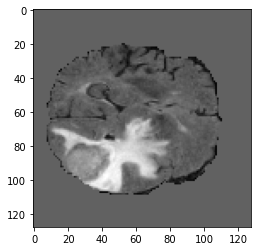

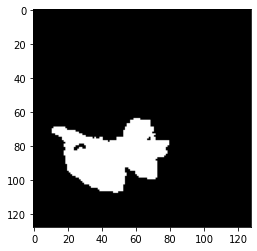

In [17]:
plt.imshow(inDist_val_data['image'][0,:,:,32], cmap='gray')
plt.show()
plt.imshow(inDist_val_data['label'][0,:,:,32], cmap='gray')

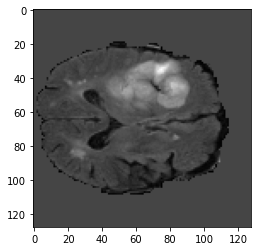

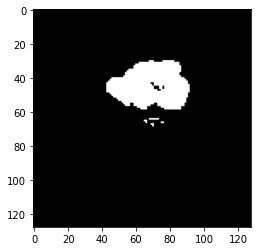

In [10]:
plt.imshow(super_offDist_data['image'][0,:,:,32], cmap='gray')
plt.show()
plt.imshow(super_offDist_data['label'][0,:,:,32], cmap='gray')

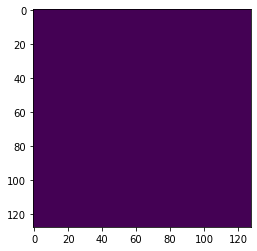

In [58]:


img = img.to(device)
g = GibbsNoiseLayer(0.).to(device)
plt.imshow(g(img).detach().cpu()[0,:,:,32])

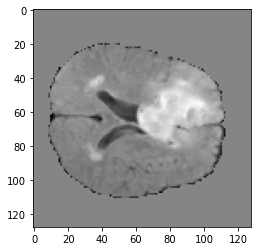

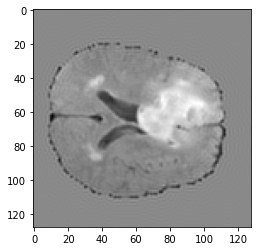

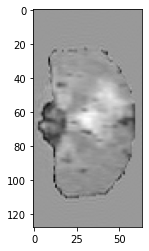

In [10]:
from filters_and_operators import (WholeTumorTCGA, 
                                   RandFourierDiskMaskd,
                                   RandPlaneWaves_ellipsoid,
                                   SaltAndPepper,
                                  )
# gibbs
MASK_RADIUS = 55
# spikes
INTENSITY = 8.
# set sampling ellipsoid
AA, BB, CC = 55.,55.,30.
# sap
PP = 0.00

data = val_ds[0]
plt.imshow(data['image'][0,:,:,32], cmap='gray')
plt.show()

t = Compose([
        RandFourierDiskMaskd(keys='image', r=MASK_RADIUS, inside_off=False, prob=1.),
        RandPlaneWaves_ellipsoid('image',AA,BB,CC, intensity_value=INTENSITY, prob=1.),
        SaltAndPepper(PP)])

data = t(data)
plt.imshow(data['image'][0,:,:,32], cmap='gray')
plt.show()
plt.imshow(data['image'][0,:,64,:], cmap='gray')
plt.show()

# Learning curves

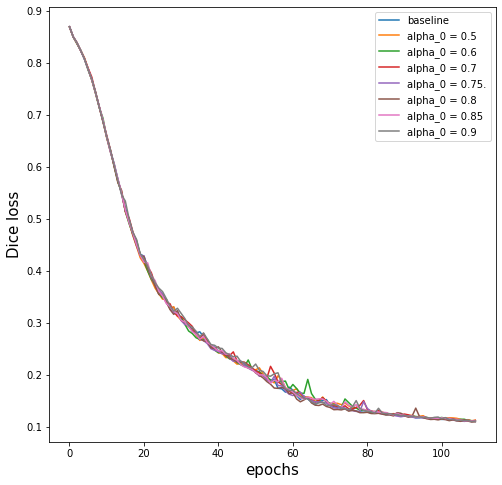

In [4]:
# learning curves 

epoch_loss_baseline = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_sourceDist_4mods_WT/epoch_loss_values_baseline_model_sourceDist_4mods_WT.txt')

epoch_loss_0p5_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.5_layer_GibbsGD_model_sourceDist_4mods_WT/epoch_loss_values_gibbs0.5_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

epoch_loss_0p6_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.6_layer_GibbsGD_model_sourceDist_4mods_WT/epoch_loss_values_gibbs0.6_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

epoch_loss_0p7_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.7_layer_GibbsGD_model_sourceDist_4mods_WT/epoch_loss_values_gibbs0.7_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

epoch_loss_0p75_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.75_layer_GibbsGD_model_sourceDist_4mods_WT/epoch_loss_values_gibbs0.75_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

epoch_loss_0p8_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.8_layer_GibbsGD_model_sourceDist_4mods_WT/epoch_loss_values_gibbs0.8_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

epoch_loss_0p85_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.85_layer_GibbsGD_model_sourceDist_4mods_WT/epoch_loss_values_gibbs0.85_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

epoch_loss_0p9_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.9_layer_GibbsGD_model_sourceDist_4mods_WT/epoch_loss_values_gibbs0.9_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

epoch_loss_0p7_freeNet_transfer = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.7_layer_GibbsGD_model_sourceDist_4mods_WT_transferUnet30epochs/epoch_loss_values_gibbs0.7_layer_GibbsGD_model_sourceDist_4mods_WT_transferUnet30epochs.txt')



plt.figure(figsize=(8,8))
plt.plot(range(len(epoch_loss_baseline)), epoch_loss_baseline, label='baseline')
plt.plot(range(len(epoch_loss_0p7_freeNet)), epoch_loss_0p5_freeNet, label='alpha_0 = 0.5')
plt.plot(range(len(epoch_loss_0p7_freeNet)), epoch_loss_0p6_freeNet, label='alpha_0 = 0.6')
plt.plot(range(len(epoch_loss_0p7_freeNet)), epoch_loss_0p7_freeNet, label='alpha_0 = 0.7')
plt.plot(range(len(epoch_loss_0p7_freeNet)), epoch_loss_0p75_freeNet, label='alpha_0 = 0.75.')
plt.plot(range(len(epoch_loss_0p7_freeNet)), epoch_loss_0p8_freeNet, label='alpha_0 = 0.8')
plt.plot(range(len(epoch_loss_0p7_freeNet)), epoch_loss_0p85_freeNet, label='alpha_0 = 0.85')
plt.plot(range(len(epoch_loss_0p7_freeNet)), epoch_loss_0p9_freeNet, label='alpha_0 = 0.9')
# plt.plot(range(len(epoch_loss_0p7_freeNet_transfer)), epoch_loss_0p7_freeNet_transfer, label='alpha_0 = 0.7. Free network. Pre-trained ResUnet.')

plt.legend()
# plt.title('Training loss from various starting', size=20)
plt.xlabel('epochs', size = 15)
plt.ylabel('Dice loss', size = 15)
plt.show()

In [6]:
ls /vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.4_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT/

epoch_loss_values_gibbs0.4_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT.txt
gibbs0.4_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT.pth
gibbs_trajectory_gibbs0.4_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT.txt
metric_values_gibbs0.4_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT.txt


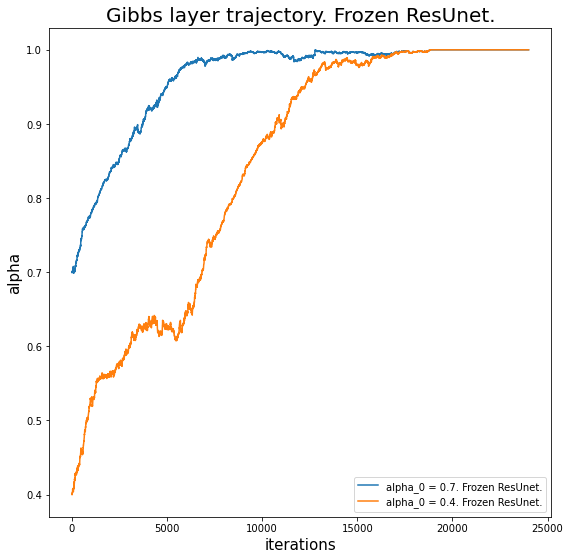

In [5]:
# learning curves 


gibbs_trajectory_0p7 = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.7_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT/gibbs_trajectory_gibbs0.7_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT.txt')

gibbs_trajectory_0p4 = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.4_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT/gibbs_trajectory_gibbs0.4_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT.txt')

plt.figure(figsize=(9,9))
plt.plot(range(len(gibbs_trajectory_0p7)), gibbs_trajectory_0p7, label='alpha_0 = 0.7. Frozen ResUnet.')
plt.plot(range(len(gibbs_trajectory_0p7)), gibbs_trajectory_0p4, label='alpha_0 = 0.4. Frozen ResUnet.')

# plt.hlines([ .115],0,110, colors='k')
plt.legend()
plt.title('Gibbs layer trajectory. Frozen ResUnet.', size=20)
plt.xlabel('iterations', size = 15)
plt.ylabel('alpha', size = 15)
# plt.ylim(0,.1)
plt.show()

In [ ]:
# learning curves 


gibbs_trajectory_0p7 = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.7_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT/gibbs_trajectory_gibbs0.7_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT.txt')

gibbs_trajectory_0p4 = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.4_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT/gibbs_trajectory_gibbs0.4_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT.txt')

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(range(len(gibbs_trajectory_0p7)), gibbs_trajectory_0p7, label='alpha_0 = 0.7. Frozen unet.')
plt.plot(range(len(gibbs_trajectory_0p7)), gibbs_trajectory_0p4, label='alpha_0 = 0.4. Frozen unet.')

# plt.hlines([ .115],0,110, colors='k')
plt.legend()
plt.title('Gibbs NN trajectory. Constant ResUnet.', size=20)
plt.xlabel('iterations', size = 15)
plt.ylabel('alpha', size = 15)
# plt.ylim(0,.1)
plt.subplot(1,2,2)

gibbs_loss_0p7 = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.7_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT/epoch_loss_values_gibbs0.7_layer_frozenUnet_GibbsGD_model_sourceDist_4mods_WT.txt')
plt.plot(range(len(gibbs_loss_0p7)), gibbs_loss_0p7, label='alpha_0 = 0.7. Frozen unet.')
plt.show()

In [6]:
import torch

torch.tensor(1)+1

tensor(2)

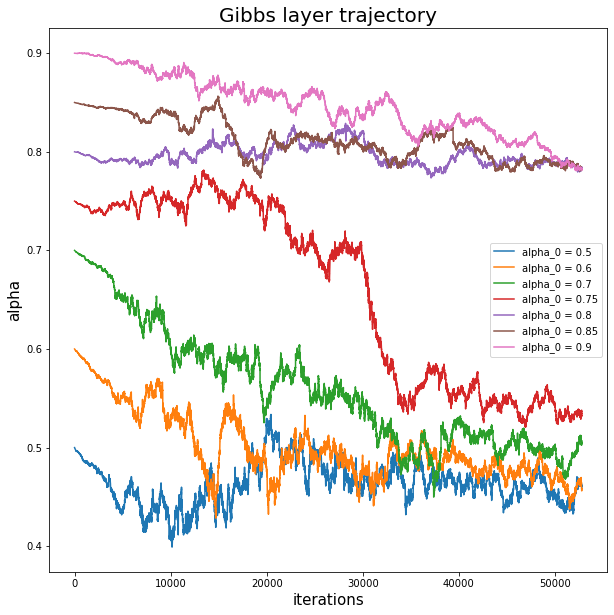

In [62]:
# Gibbs layer trajectory

gibbs_trajectory_0p5_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.5_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs_trajectory_gibbs0.5_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

gibbs_trajectory_0p6_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.6_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs_trajectory_gibbs0.6_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

gibbs_trajectory_0p7_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.7_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs_trajectory_gibbs0.7_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

gibbs_trajectory_0p75_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.75_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs_trajectory_gibbs0.75_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

gibbs_trajectory_0p8_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.8_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs_trajectory_gibbs0.8_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

gibbs_trajectory_0p85_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.85_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs_trajectory_gibbs0.85_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

gibbs_trajectory_0p9_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.9_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs_trajectory_gibbs0.9_layer_GibbsGD_model_sourceDist_4mods_WT.txt')

gibbs_trajectory_0p7_freeNet_transfer = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.7_layer_GibbsGD_model_sourceDist_4mods_WT_transferUnet30epochs/gibbs_trajectory_gibbs0.7_layer_GibbsGD_model_sourceDist_4mods_WT_transferUnet30epochs.txt')

plt.figure(figsize=(10,10))
plt.plot(range(len(gibbs_trajectory_0p7_freeNet)), gibbs_trajectory_0p5_freeNet, label='alpha_0 = 0.5')
plt.plot(range(len(gibbs_trajectory_0p7_freeNet)), gibbs_trajectory_0p6_freeNet, label='alpha_0 = 0.6')
plt.plot(range(len(gibbs_trajectory_0p7_freeNet)), gibbs_trajectory_0p7_freeNet, label='alpha_0 = 0.7')
plt.plot(range(len(gibbs_trajectory_0p7_freeNet)), gibbs_trajectory_0p75_freeNet, label='alpha_0 = 0.75')
plt.plot(range(len(gibbs_trajectory_0p7_freeNet)), gibbs_trajectory_0p8_freeNet, label='alpha_0 = 0.8')
plt.plot(range(len(gibbs_trajectory_0p7_freeNet)), gibbs_trajectory_0p85_freeNet, label='alpha_0 = 0.85')
plt.plot(range(len(gibbs_trajectory_0p7_freeNet)), gibbs_trajectory_0p9_freeNet, label='alpha_0 = 0.9')
# plt.plot(range(len(gibbs_trajectory_0p7_freeNet)), gibbs_trajectory_0p7_freeNet_transfer, label='alpha_0 = 0.7. Free network. Pre-trained ResUnet.')
# plt.hlines([ .115],0,110, colors='k')
plt.legend()
plt.title('Gibbs layer trajectory', size=20)
plt.xlabel('iterations', size = 15)
plt.ylabel('alpha', size = 15)
# plt.ylim(0,.1)
plt.show()

# Inference

In [11]:
path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/baseline_model_sourceDist_4mods_WT_testSet__2/baseline_model_sourceDist_4mods_WT_testSet__2.pth'
new_baseline_eval = model_evaluation(path, 'baseline model', in_channels=1, out_channels=1)
new_baseline_eval.add_eval('baseline_data', val_loader)
new_baseline_eval.add_eval('training data', train_loader)
new_baseline_eval.add_eval('val holdout hospital', off_dist_loader)
new_baseline_eval.add_eval('super holdout hospital', super_off_dist_loader)
new_baseline_eval.eval_dict

100%|██████████| 24/24 [00:09<00:00,  2.42it/s]


defaultdict(list,
            {'baseline_data': 0.7771030710293696,
             'training data': 0.8493584933380286,
             'val holdout hospital': 0.7710505561395125,
             'super holdout hospital': 0.8013091906905174})

In [8]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_sourceDist_4mods_WT/baseline_model_sourceDist_4mods_WT.pth'
new_baseline_eval = model_evaluation(path, 'baseline model', in_channels=1, out_channels=1)
new_baseline_eval.add_eval('baseline_data', val_loader)
new_baseline_eval.add_eval('val holdout hospital', off_dist_loader)
new_baseline_eval.add_eval('super holdout hospital', super_off_dist_loader)
new_baseline_eval.eval_dict

100%|██████████| 24/24 [00:09<00:00,  2.49it/s]


defaultdict(list,
            {'baseline_data': 0.7799423107734094,
             'val holdout hospital': 0.7539122016592459,
             'super holdout hospital': 0.7987013769646486})

In [13]:
path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/baseline_model_sourceDist_4mods_WT_testSet__2/baseline_model_sourceDist_4mods_WT_testSet__2.pth'
new_baseline_eval = model_evaluation(path, 'baseline model', in_channels=1, out_channels=1)
new_baseline_eval.add_eval('baseline_data', val_loader)
new_baseline_eval.add_eval('val holdout hospital', off_dist_loader)
new_baseline_eval.add_eval('super holdout hospital', super_off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.5_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs0.5_layer_GibbsGD_model_sourceDist_4mods_WT.pth'
gibbs0p5_freeNet = model_evaluation(path, 'alpha_0 = 0.6. Free ResUnet', in_channels=1, out_channels=1, gibbs_unet=True)
gibbs0p5_freeNet.add_eval('baseline_data', val_loader)
gibbs0p5_freeNet.add_eval('val holdout hospital', off_dist_loader)
gibbs0p5_freeNet.add_eval('super holdout hospital', super_off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.6_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs0.6_layer_GibbsGD_model_sourceDist_4mods_WT.pth'
gibbs0p6_freeNet = model_evaluation(path, 'alpha_0 = 0.6. Free ResUnet', in_channels=1, out_channels=1, gibbs_unet=True)
gibbs0p6_freeNet.add_eval('baseline_data', val_loader)
gibbs0p6_freeNet.add_eval('val holdout hospital', off_dist_loader)
gibbs0p6_freeNet.add_eval('super holdout hospital', super_off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.69_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs0.69_layer_GibbsGD_model_sourceDist_4mods_WT.pth'
gibbs0p69_freeNet = model_evaluation(path, 'alpha_0 = 0.69. Free ResUnet', in_channels=1, out_channels=1, gibbs_unet=True)
gibbs0p69_freeNet.add_eval('baseline_data', val_loader)
gibbs0p69_freeNet.add_eval('val holdout hospital', off_dist_loader)
gibbs0p69_freeNet.add_eval('super holdout hospital', super_off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.7_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs0.7_layer_GibbsGD_model_sourceDist_4mods_WT.pth'
gibbs0p7_freeNet = model_evaluation(path, 'alpha_0 = 0.7. Free ResUnet', in_channels=1, out_channels=1, gibbs_unet=True)
gibbs0p7_freeNet.add_eval('baseline_data', val_loader)
gibbs0p7_freeNet.add_eval('val holdout hospital', off_dist_loader)
gibbs0p7_freeNet.add_eval('super holdout hospital', super_off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.71_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs0.71_layer_GibbsGD_model_sourceDist_4mods_WT.pth'
gibbs0p71_freeNet = model_evaluation(path, 'alpha_0 = 0.71. Free ResUnet', in_channels=1, out_channels=1, gibbs_unet=True)
gibbs0p71_freeNet.add_eval('baseline_data', val_loader)
gibbs0p71_freeNet.add_eval('val holdout hospital', off_dist_loader)
gibbs0p71_freeNet.add_eval('super holdout hospital', super_off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.75_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs0.75_layer_GibbsGD_model_sourceDist_4mods_WT.pth'
gibbs0p75_freeNet = model_evaluation(path, 'alpha_0 = 0.75. Free ResUnet', in_channels=1, out_channels=1, gibbs_unet=True)
gibbs0p75_freeNet.add_eval('baseline_data', val_loader)
gibbs0p75_freeNet.add_eval('val holdout hospital', off_dist_loader)
gibbs0p75_freeNet.add_eval('super holdout hospital', super_off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.8_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs0.8_layer_GibbsGD_model_sourceDist_4mods_WT.pth'
gibbs0p8_freeNet = model_evaluation(path, 'alpha_0 = 0.8. Free ResUnet', in_channels=1, out_channels=1, gibbs_unet=True)
gibbs0p8_freeNet.add_eval('baseline_data', val_loader)
gibbs0p8_freeNet.add_eval('val holdout hospital', off_dist_loader)
gibbs0p8_freeNet.add_eval('super holdout hospital', super_off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.85_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs0.85_layer_GibbsGD_model_sourceDist_4mods_WT.pth'
gibbs0p85_freeNet = model_evaluation(path, 'alpha_0 = 0.85. Free ResUnet', in_channels=1, out_channels=1, gibbs_unet=True)
gibbs0p85_freeNet.add_eval('baseline_data', val_loader)
gibbs0p85_freeNet.add_eval('val holdout hospital', off_dist_loader)
gibbs0p85_freeNet.add_eval('super holdout hospital', super_off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.9_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs0.9_layer_GibbsGD_model_sourceDist_4mods_WT.pth'
gibbs0p9_freeNet = model_evaluation(path, 'alpha_0 = 0.9. Free ResUnet', in_channels=1, out_channels=1, gibbs_unet=True)
gibbs0p9_freeNet.add_eval('baseline_data', val_loader)
gibbs0p9_freeNet.add_eval('val holdout hospital', off_dist_loader)
gibbs0p9_freeNet.add_eval('super holdout hospital', super_off_dist_loader)

100%|██████████| 24/24 [00:09<00:00,  2.67it/s]


In [27]:
new_baseline_eval.eval_dict

defaultdict(list,
            {'baseline_data': 0.7799423107734094,
             'val holdout hospital': 0.7539122016592459,
             'super holdout hospital': 0.7987013769646486})

In [16]:
[int(x*96) for x in [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1]]

[48, 57, 67, 72, 76, 81, 86, 96]

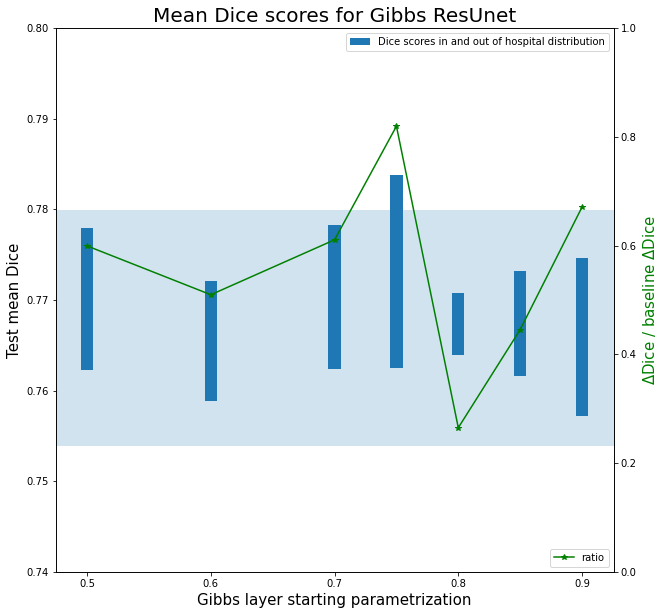

In [22]:
model_evals = [
               gibbs0p5_freeNet,
               gibbs0p6_freeNet,
               gibbs0p7_freeNet,
               gibbs0p75_freeNet,
               gibbs0p8_freeNet,
               gibbs0p85_freeNet,
               gibbs0p9_freeNet,
               new_baseline_eval]

gibbs_values = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1]

diffs = [abs(m.eval_dict['baseline_data'] - m.eval_dict['val holdout hospital']) for m in model_evals]
normalized_diffs = [x/diffs[-1] for x in diffs]

in_dist_perf = [m.eval_dict['baseline_data'] for m in model_evals]
out_dist_perf = [m.eval_dict['val holdout hospital'] for m in model_evals]

fig, ax1 = plt.subplots(figsize=(10,10))

plt.ylim(.74,.80)
ax1.set_xlabel('Gibbs layer starting parametrization', size=15)
ax1.set_ylabel('Test mean Dice',size =15)
ax1.bar(gibbs_values[:-1], height=abs(np.array(in_dist_perf[:-1])-np.array(out_dist_perf[:-1])), 
                     width=.01, bottom = np.array(out_dist_perf[:-1]), label="Dice scores in and out of hospital distribution")
# ax1.bar(1, height=abs(np.array(in_dist_perf[-1])-np.array(out_dist_perf[-1])), 
#                      width=.01, bottom = np.array(out_dist_perf[-1]), label="Dice scores for baseline model")
plt.axhspan(new_baseline_eval.eval_dict['baseline_data'], 
            new_baseline_eval.eval_dict['val holdout hospital'], alpha=.2, color=None)
plt.legend()

ax2 = ax1.twinx()
ax2.set_ylabel(r'$\Delta$Dice / baseline $\Delta$Dice', color='green', size=15)
ax2.plot(gibbs_values[:-1], normalized_diffs[:-1], '*-',c='green', label='ratio')
plt.ylim(0,1.)
plt.legend(loc=4)
plt.title('Mean Dice scores for Gibbs ResUnet', size=20)
plt.show()

In [25]:


new_baseline_eval.eval_dict

defaultdict(list,
            {'baseline_data': 0.7771030710293696,
             'val holdout hospital': 0.7710505561395125,
             'super holdout hospital': 0.8013091906905174})

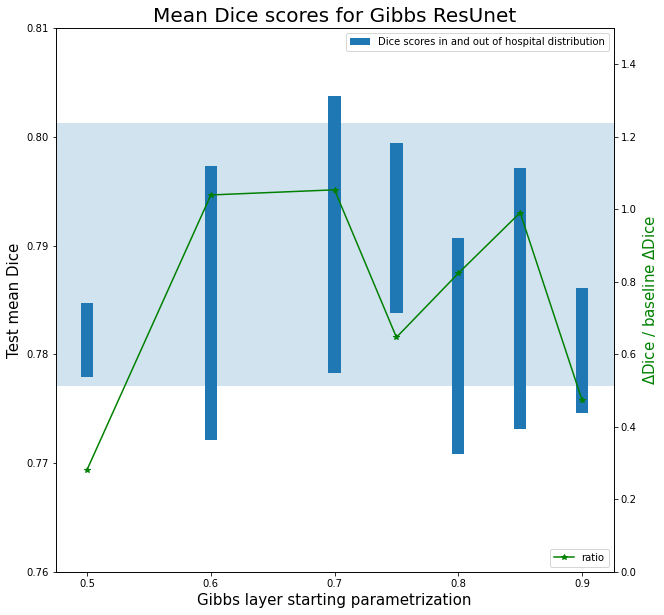

In [37]:
model_evals = [
               gibbs0p5_freeNet,
               gibbs0p6_freeNet,
               gibbs0p7_freeNet,
               gibbs0p75_freeNet,
               gibbs0p8_freeNet,
               gibbs0p85_freeNet,
               gibbs0p9_freeNet,
               new_baseline_eval]

gibbs_values = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1]

diffs = [abs(m.eval_dict['baseline_data'] - m.eval_dict['super holdout hospital']) for m in model_evals]
normalized_diffs = [x/diffs[-1] for x in diffs]

in_dist_perf = [m.eval_dict['baseline_data'] for m in model_evals]
out_dist_perf = [m.eval_dict['super holdout hospital'] for m in model_evals]

fig, ax1 = plt.subplots(figsize=(10,10))

plt.ylim(.76,.81)
ax1.set_xlabel('Gibbs layer starting parametrization', size=15)
ax1.set_ylabel('Test mean Dice',size =15)
ax1.bar(gibbs_values[:-1], height=(np.array(in_dist_perf[:-1])-np.array(out_dist_perf[:-1])), 
                     width=.01, bottom = np.array(out_dist_perf[:-1]), label="Dice scores in and out of hospital distribution")
# ax1.bar(1, height=abs(np.array(in_dist_perf[-1])-np.array(out_dist_perf[-1])), 
#                      width=.01, bottom = np.array(out_dist_perf[-1]), label="Dice scores for baseline model")
plt.axhspan(new_baseline_eval.eval_dict['baseline_data'], 
            new_baseline_eval.eval_dict['super holdout hospital'], alpha=.2, color=None)

plt.legend()

ax2 = ax1.twinx()
ax2.set_ylabel(r'$\Delta$Dice / baseline $\Delta$Dice', color='green', size=15)
ax2.plot(gibbs_values[:-1], normalized_diffs[:-1], '*-',c='green', label='ratio')
plt.ylim(0,1.5)
plt.legend(loc=4)
plt.title('Mean Dice scores for Gibbs ResUnet', size=20)
plt.show()

# Images

In [7]:
inDist_val_data = val_ds[4] #3
super_offDist_data = super_off_dist_ds[2]

In [8]:
path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/baseline_model_sourceDist_4mods_WT_testSet__2/baseline_model_sourceDist_4mods_WT_testSet__2.pth'
new_baseline_eval = model_evaluation(path, 'baseline model', in_channels=1, out_channels=1)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/gibbs0.75_layer_GibbsGD_model_sourceDist_4mods_WT/gibbs0.75_layer_GibbsGD_model_sourceDist_4mods_WT.pth'
gibbs0p75_freeNet = model_evaluation(path, 'alpha_0 = 0.75. Free ResUnet', in_channels=1, out_channels=1, gibbs_unet=True)

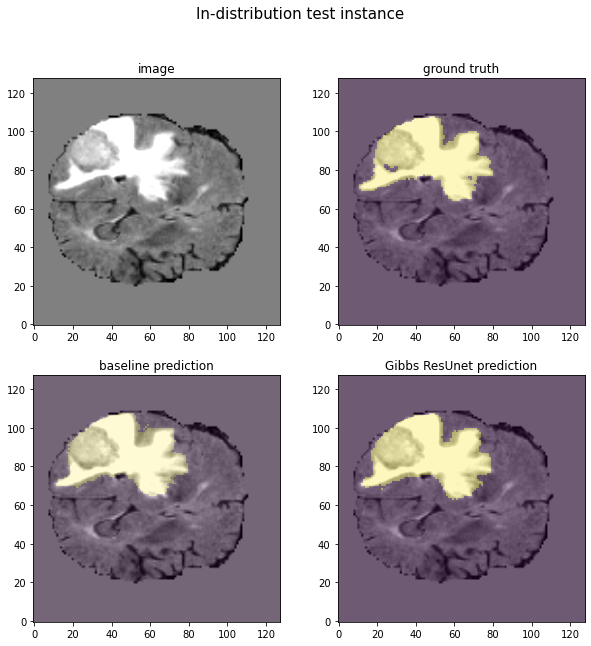

In [18]:
baseline_inDist = new_baseline_eval.model(inDist_val_data['image'][None,:].cuda())
baseline_inDist = AsDiscrete(threshold_values=True)(
    torch.sigmoid(baseline_inDist)).detach().cpu().numpy()

gibb_inDist = gibbs0p75_freeNet.model(inDist_val_data['image'][None,:].cuda())
gibb_inDist = AsDiscrete(threshold_values=True)(
    torch.sigmoid(gibb_inDist)).detach().cpu().numpy()

VAL = 2
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('image')
plt.imshow(inDist_val_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.subplot(2,2,2)
plt.title('ground truth')
base = plt.imshow(inDist_val_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(inDist_val_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(inDist_val_data['label'][0,:,:,32], origin='lower', interpolation='nearest', alpha=0.3)
plt.subplot(2,2,3)
plt.title('baseline prediction')
plt.imshow(inDist_val_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(baseline_inDist[0,0,:,:,32], origin='lower', interpolation='nearest', alpha=0.3)
plt.subplot(2,2,4)
plt.title('Gibbs ResUnet prediction')
plt.imshow(inDist_val_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(gibb_inDist[0,0,:,:,32], origin='lower', interpolation='nearest', alpha=0.3)
plt.suptitle('In-distribution test instance', size=15)
plt.show()

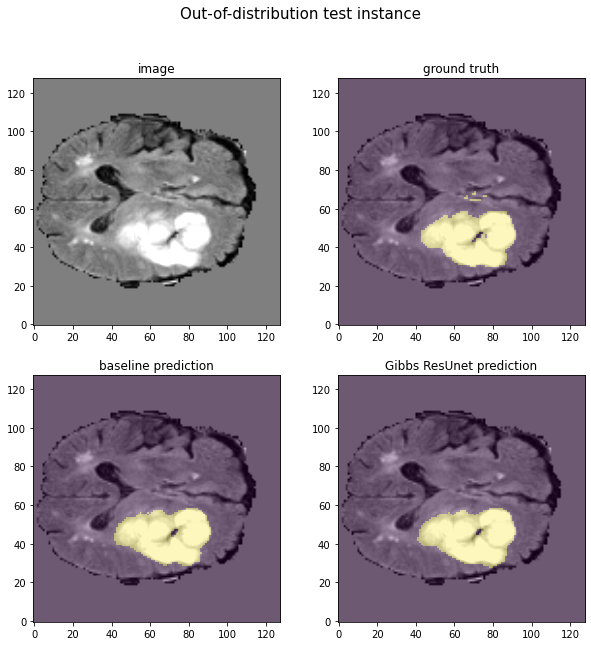

In [19]:
baseline_inDist = new_baseline_eval.model(super_offDist_data['image'][None,:].cuda())
baseline_inDist = AsDiscrete(threshold_values=True)(
    torch.sigmoid(baseline_inDist)).detach().cpu().numpy()

gibb_inDist = gibbs0p75_freeNet.model(super_offDist_data['image'][None,:].cuda())
gibb_inDist = AsDiscrete(threshold_values=True)(
    torch.sigmoid(gibb_inDist)).detach().cpu().numpy()


VAL = 2
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('image')
plt.imshow(super_offDist_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.subplot(2,2,2)
plt.title('ground truth')
plt.imshow(super_offDist_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(super_offDist_data['label'][0,:,:,32], origin='lower', interpolation='nearest', alpha=0.3)
plt.subplot(2,2,3)
plt.title('baseline prediction')
plt.imshow(super_offDist_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(baseline_inDist[0,0,:,:,32], origin='lower', interpolation='nearest', alpha=0.3)
plt.subplot(2,2,4)
plt.title('Gibbs ResUnet prediction')
plt.imshow(super_offDist_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(gibb_inDist[0,0,:,:,32], origin='lower', interpolation='nearest', alpha=0.3)
plt.suptitle('Out-of-distribution test instance', size=15)
plt.show()

Let's segment img_g

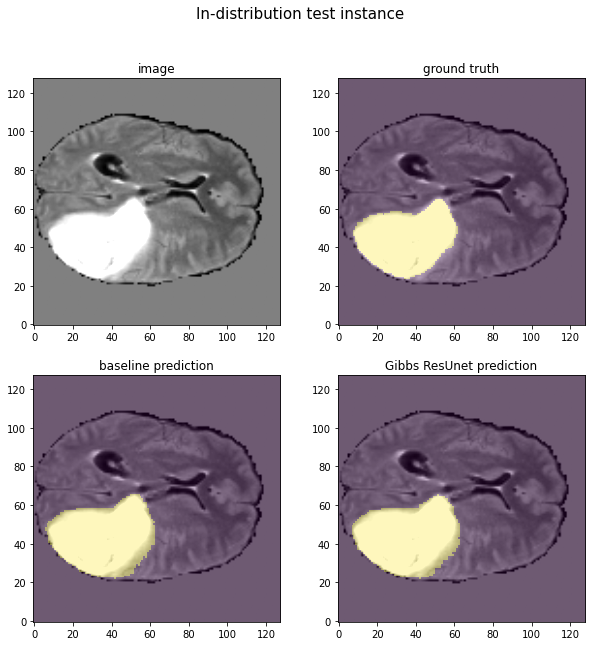

In [21]:
inDist_val_data = val_ds[10] #3



#####
baseline_inDist = new_baseline_eval.model(inDist_val_data['image'][None,:].cuda())
baseline_inDist = AsDiscrete(threshold_values=True)(
    torch.sigmoid(baseline_inDist)).detach().cpu().numpy()

gibb_inDist = gibbs0p75_freeNet.model(inDist_val_data['image'][None,:].cuda())
gibb_inDist = AsDiscrete(threshold_values=True)(
    torch.sigmoid(gibb_inDist)).detach().cpu().numpy()

VAL = 2
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('image')
plt.imshow(inDist_val_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.subplot(2,2,2)
plt.title('ground truth')
base = plt.imshow(inDist_val_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(inDist_val_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(inDist_val_data['label'][0,:,:,32], origin='lower', interpolation='nearest', alpha=0.3)
plt.subplot(2,2,3)
plt.title('baseline prediction')
plt.imshow(inDist_val_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(baseline_inDist[0,0,:,:,32], origin='lower', interpolation='nearest', alpha=0.3)
plt.subplot(2,2,4)
plt.title('Gibbs ResUnet prediction')
plt.imshow(inDist_val_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(gibb_inDist[0,0,:,:,32], origin='lower', interpolation='nearest', alpha=0.3)
plt.suptitle('In-distribution test instance', size=15)
plt.show()


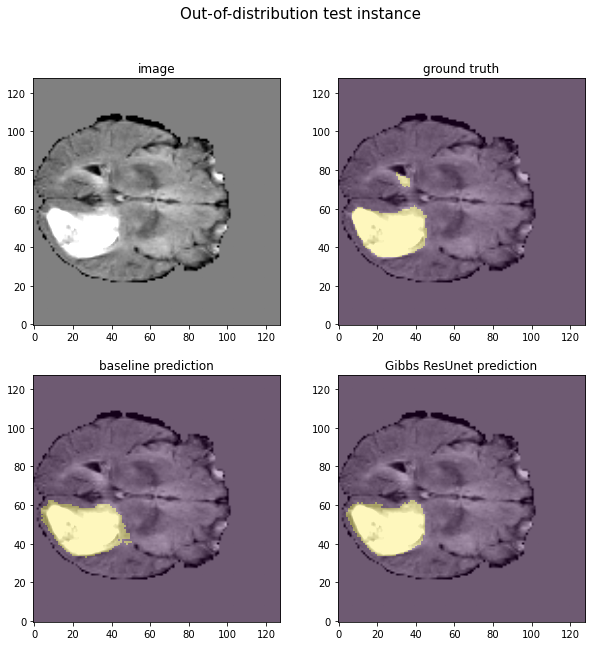

In [31]:
super_offDist_data = super_off_dist_ds[1]
##

baseline_inDist = new_baseline_eval.model(super_offDist_data['image'][None,:].cuda())
baseline_inDist = AsDiscrete(threshold_values=True)(
    torch.sigmoid(baseline_inDist)).detach().cpu().numpy()

gibb_inDist = gibbs0p75_freeNet.model(super_offDist_data['image'][None,:].cuda())
gibb_inDist = AsDiscrete(threshold_values=True)(
    torch.sigmoid(gibb_inDist)).detach().cpu().numpy()

VAL = 2
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('image')
plt.imshow(super_offDist_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.subplot(2,2,2)
plt.title('ground truth')
plt.imshow(super_offDist_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(super_offDist_data['label'][0,:,:,32], origin='lower', interpolation='nearest', alpha=0.3)
plt.subplot(2,2,3)
plt.title('baseline prediction')
plt.imshow(super_offDist_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(baseline_inDist[0,0,:,:,32], origin='lower', interpolation='nearest', alpha=0.3)
plt.subplot(2,2,4)
plt.title('Gibbs ResUnet prediction')
plt.imshow(super_offDist_data['image'][0,:,:,32], cmap='gray', origin='lower', vmin=-VAL, vmax=VAL, interpolation='bilinear')
plt.imshow(gibb_inDist[0,0,:,:,32], origin='lower', interpolation='nearest', alpha=0.3)
plt.suptitle('Out-of-distribution test instance', size=15)
plt.show()

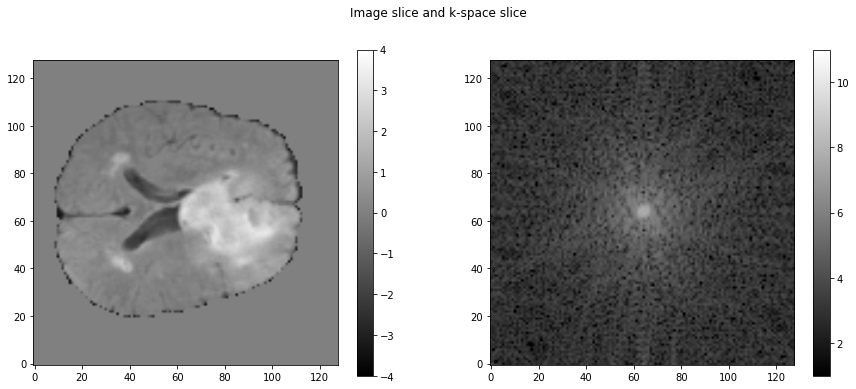

In [41]:
show_slice_and_fourier(fixed_img[0,:,:,32],0,8, 6, 10)

In [42]:
fixed_img.size()

torch.Size([1, 128, 128, 64])